## 3. Sentiment Analysis - Modeling with Stopwords
---

### Contents:
- [Modeling](#Modeling)
- [Finding Best Model Parameters](#BestModel)
- [Summary of Model Performance](#ModelSummary)
- [Evaluation of Logistic Regression Model (Best Performance)](#LRModel)
- [Model Adjustments / More Feature Engineering](#Modeling2)

In [4]:
#importing libraries 

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

import joblib
import xgboost as xgb

import time
from itertools import cycle


In [5]:
# !pip install joblib

In [6]:
pd.set_option('display.max_columns',150)
pd.set_option('display.max_rows',1500)

<a id='Modeling'></a>

## Modeling
---

Similar to the previous segment, we will use the following models to classify the tweets. The main difference is that the stopwords have been retained.

##### Models Used: 
- Multiple models; including Logistic Regression Model, Multinomial Naive Bayes Model, Decision Tree, Random Forest, Ada Boost, Gradient Boost and XGBoost were used

##### Methodology
- A pipeline with CountVectoriser, TFIDF Transformer and the above models was set up
- Grid Search was used to optimise the number of features and parameters 

##### Metric to Validate Model: 

Accuracy score was used.

##### Outcome:

The Logistic Regression Model was able to accurately classify 80.1% of the posts. An improvement from the previous model. As such, it can be concluded that the inclusion of stopwords help in model classification.

In [7]:
filepath = '../datasets/tweets_clean_3.csv'

In [8]:
df_1 = pd.read_csv(filepath)

In [9]:
df_1.head()

,text,airline_sentiment
0,what said,1
1,plu you ve ad commerci to the experi tacki,2
2,didn today must mean need to take anoth trip,1
3,it realli aggress to blast obnoxi entertain in...,0
4,and it realli big bad thing about it,0


### Modeling 

General Approach
- Split data into X and y 
- Train test split for model validation
- Hyperparameter optimisation for count vectoriser, Tfidf transformer and model hyperparameters


##### Split data into `X` and `y`.

In [10]:
X = df_1['text']
y = df_1['airline_sentiment']

In [11]:
X.head()

0                                            what said
1           plu you ve ad commerci to the experi tacki
2         didn today must mean need to take anoth trip
3    it realli aggress to blast obnoxi entertain in...
4                 and it realli big bad thing about it
Name: text, dtype: object

#### Baseline Accuracy 
Baseline accuracy for model is 62.7%

In [12]:
y.value_counts(normalize=True)

0    0.627149
1    0.211698
2    0.161153
Name: airline_sentiment, dtype: float64

#### Checking Max Features

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                y,
                                                random_state=42,
                                                stratify = y)

In [14]:
cvec = CountVectorizer()

In [15]:
X_cvec = cvec.fit_transform(X_train)

In [16]:
X_cvec.shape

(10950, 7791)

In [17]:
X_feature_names = cvec.get_feature_names()
X_feature_names

['a1',
 'a15',
 'a18',
 'a20',
 'a3',
 'a319',
 'a320',
 'a321',
 'a330',
 'a3zz0f',
 'a4',
 'a49',
 'a60',
 'a8',
 'a9',
 'aa',
 'aa106',
 'aa111',
 'aa1119',
 'aa1224',
 'aa1237',
 'aa138',
 'aa1457',
 'aa1458',
 'aa1469',
 'aa153',
 'aa157',
 'aa1657',
 'aa1675',
 'aa1679',
 'aa1691',
 'aa199',
 'aa200',
 'aa215',
 'aa2227',
 'aa223',
 'aa2334',
 'aa2401',
 'aa2402',
 'aa2416',
 'aa2444',
 'aa2450',
 'aa2595',
 'aa291',
 'aa2924',
 'aa3031so',
 'aa304',
 'aa3186',
 'aa3195',
 'aa3230',
 'aa3390',
 'aa3490',
 'aa362',
 'aa363',
 'aa3688',
 'aa375',
 'aa4285',
 'aa45',
 'aa5',
 'aa504',
 'aa65',
 'aa67',
 'aa76',
 'aa91',
 'aa919',
 'aa953',
 'aa973',
 'aa977',
 'aaaand',
 'aaalwaysl',
 'aadavantag',
 'aadelay',
 'aadv',
 'aadvantag',
 'aal',
 'aaron',
 'aateam',
 'ab',
 'abandon',
 'abbrev',
 'abc',
 'abcletjetbluestreamfe',
 'abcnew',
 'abi',
 'abil',
 'abl',
 'aboard',
 'abound',
 'about',
 'abov',
 'abq',
 'absolut',
 'absorb',
 'absoulut',
 'absurd',
 'absurdli',
 'abt',
 'abund'

<a id='BestModel'></a>

### Finding Best Model Parameters
##### Function for model validation

In [18]:
def run_model(model_type, X,y):
    
    #train test split data for model validation
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify = y)

    #specifying models
    models = {'lr': LogisticRegression(), 
              'lr_bal': LogisticRegression(class_weight='balanced'), 
              'nb': MultinomialNB(),
              'dt': DecisionTreeClassifier(),
              'rf': RandomForestClassifier(),
              'ada': AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),
              'gb': GradientBoostingClassifier(),
              'xgb': xgb.XGBClassifier(objective='multi:softmax',num_class=3) 
             }
             
    
    #creating a pipeline
    pipe = Pipeline([
        ('cvec', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        (model_type, models[model_type])
    ])
    
    #pipeline parameters
    pipe_params = {
    'cvec__max_df': (.9, .8),
    'cvec__max_features':[2500,5000,7000],
    'cvec__max_df':[0.9,0.95],
    'cvec__ngram_range':[(1,1),(1,2)],
    'tfidf__use_idf':[True,False],

    }
        
    #additional parameters for each model 
    if model_type == 'nb':
        pipe_params.update({'nb__alpha':[1,2]
                           })
        
    elif model_type == 'lr':
        pipe_params.update({'lr__penalty':['none','l2'],
                            'lr__max_iter':[1000]
                           })
        
    elif model_type == 'dt':
        pipe_params.update({'dt__max_depth':[3,5,10],
                           'dt__min_samples_split':[5,10,20],
                           'dt__min_samples_leaf':[2,5,7]
                           })
    
    elif model_type == 'rf':
        pipe_params.update({'rf__n_estimators': [100,150,200],
                            'rf__max_depth':[None,1,2,3,4,5]
                           })
    elif model_type == 'ada':
        pipe_params.update({'ada__n_estimators':[50,100],
                            'ada__learning_rate':[0.9,1],
                            'ada__base_estimator__max_depth':[1,2,3]
                           })
    elif model_type == 'gb':
        pipe_params.update({'gb__n_estimators': [50,100,150],
                            'gb__learning_rate':[0.08, 0.1, 0.12],
                            'gb__max_depth':[1,2,3]
        })
        
    elif model_type == 'xgb':
        pipe_params.update({'xgb__max_depth':[1,2,3]
        })
        
    elif model_type == 'lr_bal':
        pipe_params.update({'lr_bal__penalty':['none','l2'],
                            'lr_bal__max_iter':[1000]
                           })


    #grid search 
    gs = GridSearchCV(estimator = pipe, 
                        param_grid = pipe_params,
                        verbose = 1,
                        n_jobs = -1, 
                        cv = 5)
    
    print("Grid Search for " + model_type)
    print('===========================================================================')
    
    gs.fit(X_train,y_train)

    print(f"Best Score: {gs.best_score_}")
    print(f"Best Parameters: {gs.best_params_}")
    
    #train model on entire train data set using  best parameters
    pipeline_final= Pipeline([
    ('cvec', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    (model_type, models[model_type])
    ])
    
    pipeline_final.set_params(**gs.best_params_)
    final_model = pipeline_final.fit(X_train,y_train)
    
    print("Final Model Score")
    print()
    print(f'Train Score:{final_model.score(X_train,y_train)}')
    print(f'Test Score:{final_model.score(X_test,y_test)}')
    
    # add timestring to file name
    timestr = time.strftime("%Y%m%d-%H%M%S")

    #save model with best parameters for use later
    filename = 'model_' + model_type + '_sw_' + timestr +'.pkl'
    joblib.dump(final_model,filename)



### Logistic Regression Model


In [19]:
run_model('lr',X,y)

Grid Search for lr
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  6.8min finished


Best Score: 0.7979908675799086
Best Parameters: {'cvec__max_df': 0.9, 'cvec__max_features': 5000, 'cvec__ngram_range': (1, 2), 'lr__max_iter': 1000, 'lr__penalty': 'l2', 'tfidf__use_idf': True}
Final Model Score

Train Score:0.88
Test Score:0.8019720624486442


### Naive Bayes Model

In [20]:
run_model('nb',X,y)

Grid Search for nb
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   36.7s finished


Best Score: 0.7440182648401826
Best Parameters: {'cvec__max_df': 0.9, 'cvec__max_features': 2500, 'cvec__ngram_range': (1, 2), 'nb__alpha': 1, 'tfidf__use_idf': True}
Final Model Score

Train Score:0.7872146118721461
Test Score:0.7482881402355519


### Decision Tree Model

In [21]:
run_model('dt',X,y)

Grid Search for dt
Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed: 10.0min finished


Best Score: 0.6858447488584475
Best Parameters: {'cvec__max_df': 0.9, 'cvec__max_features': 5000, 'cvec__ngram_range': (1, 1), 'dt__max_depth': 10, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 20, 'tfidf__use_idf': True}
Final Model Score

Train Score:0.7100456621004566
Test Score:0.6814571350314982


### Random Forest Model

In [22]:
run_model('rf',X,y)

Grid Search for rf
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 36.0min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 46.2min finished


Best Score: 0.7657534246575343
Best Parameters: {'cvec__max_df': 0.95, 'cvec__max_features': 2500, 'cvec__ngram_range': (1, 2), 'rf__max_depth': None, 'rf__n_estimators': 200, 'tfidf__use_idf': True}
Final Model Score

Train Score:0.9940639269406393
Test Score:0.761709120788825


### Ada Boost Model

In [23]:
run_model('ada',X,y)

Grid Search for ada
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 24.9min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 34.9min finished


Best Score: 0.7530593607305935
Best Parameters: {'ada__base_estimator__max_depth': 2, 'ada__learning_rate': 0.9, 'ada__n_estimators': 100, 'cvec__max_df': 0.9, 'cvec__max_features': 2500, 'cvec__ngram_range': (1, 1), 'tfidf__use_idf': False}
Final Model Score

Train Score:0.8032876712328767
Test Score:0.7551355792933443


### Gradient Boost

In [22]:
run_model('gb',X,y)

Grid Search for gb
Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 31.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 54.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 81.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 111.7min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 147.2min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed: 150.5min finished


Best Score: 0.7619178082191781
Best Parameters: {'cvec__max_df': 0.9, 'cvec__max_features': 5000, 'cvec__ngram_range': (1, 2), 'gb__learning_rate': 0.12, 'gb__max_depth': 3, 'gb__n_estimators': 150, 'tfidf__use_idf': True}
Final Model Score

Train Score:0.811689497716895
Test Score:0.7515749109832922


### XG Boost

In [27]:
run_model('xgb',X,y)

Grid Search for xgb
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 10.2min finished


Best Score: 0.7796347031963471
Best Parameters: {'cvec__max_df': 0.9, 'cvec__max_features': 7000, 'cvec__ngram_range': (1, 1), 'tfidf__use_idf': False, 'xgb__max_depth': 3}
Final Model Score

Train Score:0.8300456621004566
Test Score:0.7748562037797864


<a id='ModelSummary'></a>

### Model Performance

- Slight improvement in the overall model accuracy scores when stopwords were added. Improvement of 2% from 78.1 - 80.1%.


| Model                    | Accuracy Score |
|--------------------------|----------------|
| Logistic Regression      | 0\.801         |
| Naive Bayes              | 0\.748         |
| Decision Tree            | 0\.681         |
| Random Forest Classifier | 0\.761         |
| Ada Boost                | 0\.755         |
| Gradient Boost           | 0\.751         |
| XG Boost                 | 0\.774         |


<a id='LRModel'></a>

### Analysing Results of Best Model: Logistic Regression

##### Model Results & Confusion Matrix

In [19]:
#get results for best model
filename = 'model_lr_sw.pkl'
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, y_test)
print(result)

0.8019720624486442


In [20]:
predictions_lr = loaded_model.predict(X_test)

In [21]:
cm_lr = confusion_matrix(y_test,predictions_lr)

cm_df_lr = pd.DataFrame(cm_lr, 
                       columns = ['Pred Negative','Pred Neutral', 'Pred Positive'],
                      index = ['Actual Negative','Actual Neutral', 'Actual Positive'])
cm_df_lr

,Pred Negative,Pred Neutral,Pred Positive
Actual Negative,2162,99,29
Actual Neutral,306,422,45
Actual Positive,168,76,344


In [22]:
print(classification_report(y_test,predictions_lr,digits=3))

              precision    recall  f1-score   support

           0      0.820     0.944     0.878      2290
           1      0.707     0.546     0.616       773
           2      0.823     0.585     0.684       588

    accuracy                          0.802      3651
   macro avg      0.783     0.692     0.726      3651
weighted avg      0.797     0.802     0.791      3651



##### Looking at misclassified tweets

- It can generally be seen that the misclassified tweets do not have much context and one way is to keep stopwords to see if that improves the model performance.

In [21]:
pred = pd.DataFrame(predictions_lr,columns=['pred'],index=y_test.index)

agg_tweets = pd.concat([X_test,y_test,pred],axis=1,sort=False)
# agg_tweets

In [22]:
#viewing misclassified posts
agg_tweets[agg_tweets['airline_sentiment'] != agg_tweets['pred']]

,text,airline_sentiment,pred
8274,and of cours that wa suppos to say logan not l...,1,0
8554,done also look like you open some up on my fli...,2,1
12931,board in min yay,1,0
10639,land at phoenix but we had to board flight qui...,1,0
7552,unfortun wa so startl and rush didn get the na...,0,1
4964,my fav,2,0
6568,haha yeah did just make joke,1,2
4686,when will the flight resum don see it in the o...,0,1
7137,our fleet on fleek realli jetblu fleek face_wi...,0,1
11839,will do hope for voucher for futur flight opti...,2,1


##### ROC-AUC Performance for Individual Classes

In [23]:
# Using a multiclass classifier to obtain the respective scores 
clf = OneVsRestClassifier(loaded_model)
y_score = clf.fit(X_train, y_train).decision_function(X_test)

In [24]:
# Binarize the output
y_test = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test.shape[1]

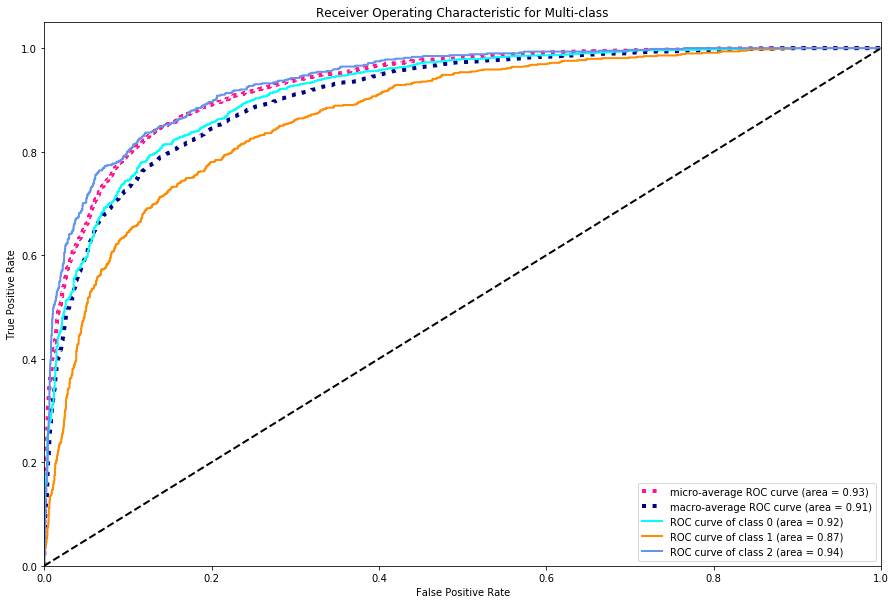

In [25]:
n_classes = 3 

# Compute ROC curve and ROC area for each class
fpr = dict()    #false positive rate
tpr = dict()    #true positive rate 
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, linewidth=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-class')
plt.legend(loc="lower right")
plt.show()

In [26]:
y_prob = clf.predict_proba(X_test)

macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")

print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-Rest ROC AUC scores:
0.909468 (macro),
0.911072 (weighted by prevalence)


### Top and Bottom 10 Words for Each Class

In [27]:
loaded_model.named_steps['lr'].coef_

array([[-0.45631089,  0.05997811, -0.53930838, ...,  0.17797271,
         0.44146001, -0.39368314],
       [ 0.46447673,  0.3900994 ,  0.60664802, ..., -0.29957821,
        -0.29682565,  0.34371514],
       [-0.00816584, -0.45007751, -0.06733964, ...,  0.1216055 ,
        -0.14463436,  0.04996799]])

In [28]:
for i, tag in enumerate(clf.classes_):
    coefficients = loaded_model.named_steps['lr'].coef_[i]
    weights = list(zip(loaded_model.named_steps['cvec'].get_feature_names(),coefficients))
    print('Tag:',tag)
    
    print('Most Positive Coefficients:')
    print(sorted(weights,key=lambda x: -x[1])[:10])
    
    print('=======================================')
    
    print('Most Negative Coefficients:')
    print(sorted(weights,key=lambda x: x[1])[:10])
    
    print('***************************************')
    print()

Tag: 0
Most Positive Coefficients:
[('delay', 3.8642785235946486), ('hour', 3.840886644845847), ('not', 3.6517479270328193), ('no', 3.1276166034249284), ('your', 2.5894554035377895), ('noth', 2.5255577051246743), ('worst', 2.5212188214794344), ('hr', 2.3654660274029196), ('whi', 2.36259389765093), ('bag', 2.2502541690321367)]
Most Negative Coefficients:
[('thank', -5.079049540406138), ('love', -2.784549715614882), ('great', -2.3990571633649838), ('thank you', -2.122752423006724), ('awesom', -2.0877794550112907), ('amaz', -1.9086101136085656), ('no worri', -1.653470402403809), ('good', -1.5601632522642799), ('best', -1.4994097979171344), ('destinationdragon', -1.4261479208103078)]
***************************************

Tag: 1
Most Positive Coefficients:
[('is there', 2.060650796873162), ('can you', 1.9994450950152436), ('is your', 1.5462978955554811), ('do you', 1.5356062653597886), ('dm', 1.4861245266734395), ('hi', 1.372641327232014), ('current', 1.353424912868434), ('or', 1.2959310